In [94]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten, TimeDistributed, concatenate
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
import datetime
from scipy.signal import argrelextrema
from collections import deque
from matplotlib.lines import Line2D
from tensorflow.keras.callbacks import EarlyStopping
import keras
from ti_calculating import *

## Setup Training Data

In [95]:
# Import data for training

train_data = pd.read_csv("/home/deepfintech/Codes/Model/Crypto/BTCUSDT/BTCUSDT_Aug_7_mon.csv")

train_data.head()

,open_time,open,high,low,close,volume,asset_volume,number_of_trades,taker_buy_base,taker_buy_quote
0,2021-08-01 00:00:00,41461.84,41485.34,41400.01,41427.76,110.044539,4.561223e+06,2577,43.195582,1.790524e+06
1,2021-08-01 00:01:00,41427.76,41445.77,41264.29,41264.29,98.983582,4.090711e+06,2816,46.836211,1.935687e+06
2,2021-08-01 00:02:00,41268.62,41312.14,41120.00,41150.01,315.369492,1.299250e+07,5859,128.445229,5.291558e+06
3,2021-08-01 00:03:00,41150.00,41289.54,41131.59,41289.53,99.097203,4.083800e+06,2392,43.253533,1.782644e+06
4,2021-08-01 00:04:00,41289.52,41350.04,41277.74,41350.04,56.540719,2.335761e+06,1563,30.139970,1.245214e+06


In [96]:
train_data['open_time'] = pd.to_datetime(train_data['open_time'])

train_data_copy = train_data.copy()

In [97]:
# Get only "open","high","low","close","volume" columns.

columns = ["open","high","low","close","volume"]
train_data = train_data[columns]
train_data.head()

,open,high,low,close,volume
0,41461.84,41485.34,41400.01,41427.76,110.044539
1,41427.76,41445.77,41264.29,41264.29,98.983582
2,41268.62,41312.14,41120.00,41150.01,315.369492
3,41150.00,41289.54,41131.59,41289.53,99.097203
4,41289.52,41350.04,41277.74,41350.04,56.540719


In [98]:
train_data['open_time'] = train_data_copy['open_time'].apply(lambda x: x.weekday()*24*60+x.hour*60+x.minute)

In [99]:
high_idx = argrelextrema(train_data['high'].values, np.greater, order=2)[0]
low_idx = argrelextrema(train_data['low'].values, np.less, order=2)[0]

close_high_idx = argrelextrema(train_data['close'].values, np.greater, order=2)[0]
close_low_idx = argrelextrema(train_data['close'].values, np.less, order=2)[0]

high_low_idx = np.sort(np.concatenate((close_high_idx, close_low_idx), axis=0), axis=0)

In [100]:
train_data["approx"] = np.nan
train_data["app_highs"] = np.nan
train_data["app_lows"] = np.nan

train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,41461.84,41485.34,41400.01,41427.76,110.044539,8640,NaN,NaN,NaN
1,41427.76,41445.77,41264.29,41264.29,98.983582,8641,NaN,NaN,NaN
2,41268.62,41312.14,41120.00,41150.01,315.369492,8642,NaN,NaN,NaN
3,41150.00,41289.54,41131.59,41289.53,99.097203,8643,NaN,NaN,NaN
4,41289.52,41350.04,41277.74,41350.04,56.540719,8644,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
304886,43193.56,43193.57,43114.75,43149.02,52.813750,1436,NaN,NaN,NaN
304887,43149.02,43162.86,43129.88,43162.85,37.293670,1437,NaN,NaN,NaN
304888,43162.86,43209.48,43151.41,43205.75,41.563700,1438,NaN,NaN,NaN
304889,43205.74,43205.75,43156.66,43160.00,43.190100,1439,NaN,NaN,NaN


In [101]:
train_data["approx"].iloc[high_low_idx] = train_data['close'].iloc[high_low_idx]
train_data["app_highs"].iloc[high_idx] = train_data['high'].iloc[high_idx]
train_data["app_lows"].iloc[low_idx] = train_data['low'].iloc[low_idx]

/home/deepfintech/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [102]:
train_data["approx"] = train_data["approx"].interpolate(method='piecewise_polynomial')
train_data["app_highs"] = train_data["app_highs"].interpolate(method='piecewise_polynomial')
train_data["app_lows"] = train_data["app_lows"].interpolate(method='piecewise_polynomial')

In [103]:
train_data["approx"].iloc[0] = train_data['close'].iloc[0]
train_data["approx"].iloc[-1] = train_data['close'].iloc[-1]

train_data["app_highs"].iloc[0] = train_data['high'].iloc[0]
train_data["app_highs"].iloc[-1] = train_data['high'].iloc[-1]

train_data["app_lows"].iloc[0] = train_data['low'].iloc[0]
train_data["app_lows"].iloc[-1] = train_data['low'].iloc[-1]

In [104]:
train_data["approx"] = train_data["approx"].interpolate(method='piecewise_polynomial')
train_data["app_highs"] = train_data["app_highs"].interpolate(method='piecewise_polynomial')
train_data["app_lows"] = train_data["app_lows"].interpolate(method='piecewise_polynomial')

In [105]:
train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,41461.84,41485.34,41400.01,41427.76,110.044539,8640,41427.760000,41485.340000,41400.010000
1,41427.76,41445.77,41264.29,41264.29,98.983582,8641,41288.885000,41496.870000,41260.005000
2,41268.62,41312.14,41120.00,41150.01,315.369492,8642,41150.010000,41508.400000,41120.000000
3,41150.00,41289.54,41131.59,41289.53,99.097203,8643,41273.446667,41519.930000,41169.524286
4,41289.52,41350.04,41277.74,41350.04,56.540719,8644,41396.883333,41531.460000,41219.048571
...,...,...,...,...,...,...,...,...,...
304886,43193.56,43193.57,43114.75,43149.02,52.813750,1436,43149.020000,43259.405556,43114.750000
304887,43149.02,43162.86,43129.88,43162.85,37.293670,1437,43177.385000,43251.286667,43124.982500
304888,43162.86,43209.48,43151.41,43205.75,41.563700,1438,43205.750000,43243.167778,43135.215000
304889,43205.74,43205.75,43156.66,43160.00,43.190100,1439,43160.000000,43235.048889,43145.447500


<hr style="border:2px solid blue"> </hr>

### **ABCD Pattern for training**

In [106]:
look_order = 50

def getABCD(data):
    max_idx = argrelextrema(data['close'].values, np.greater, order=look_order)[0]
    min_idx = argrelextrema(data['close'].values, np.less, order=look_order)[0]

    min_max_list = np.concatenate((min_idx, max_idx))
    min_max_list.sort()

    new_max_list = []
    temp_max_list = []

    new_min_list = []
    temp_min_list = []

    for count, idx in enumerate(min_max_list):
        if idx in max_idx:
            temp_max_list.append(idx)
            if(len(temp_min_list)>0):
                new_min_list.append(temp_min_list)
                temp_min_list = []
        else:
            temp_min_list.append(idx)
            if(len(temp_max_list)>0):
                new_max_list.append(temp_max_list)
                temp_max_list=[]

    if(len(temp_max_list)>0):
        new_max_list.append(temp_max_list)
    if(len(temp_min_list)>0):
        new_min_list.append(temp_min_list)


    global_max_list = []
    global_min_list = []

    for i in new_max_list:
        global_max_list.append(data.iloc[i]['close'].idxmax())

    for i in new_min_list:
        global_min_list.append(data.iloc[i]['close'].idxmin())

    global_min_max_list = np.concatenate((global_min_list, global_max_list))
    global_min_max_list.sort()
    
    return global_min_list, global_max_list, global_min_max_list

train_global_min_list, train_global_max_list, train_global_min_max_list = getABCD(train_data)


<ipython-input-107-687c820f183e>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(train_data_copy.iloc[train_global_min_max_list].open_time, train_data.iloc[train_global_min_max_list]['close'],color=colors[3], lineStyle='--')


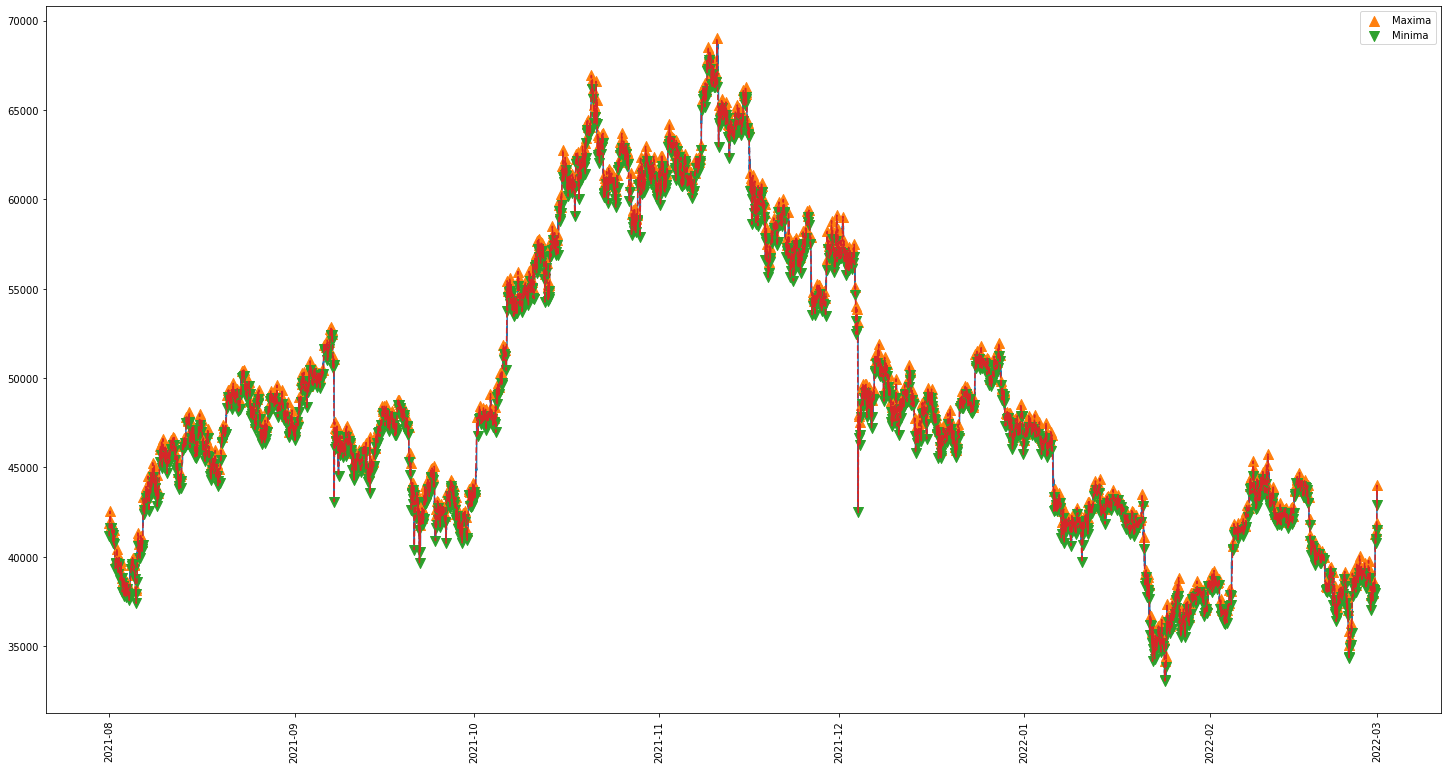

In [107]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.figure(figsize=(25, 13))
plt.plot(train_data_copy.open_time , train_data['close'], zorder=0)
plt.scatter(train_data_copy.iloc[train_global_max_list].open_time, train_data.iloc[train_global_max_list]['close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(train_data_copy.iloc[train_global_min_list].open_time, train_data.iloc[train_global_min_list]['close'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.plot(train_data_copy.iloc[train_global_min_max_list].open_time, train_data.iloc[train_global_min_max_list]['close'],color=colors[3], lineStyle='--')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [108]:
# train_data['global_min_max'] = np.nan

# train_data['global_min_max'] = train_data.iloc[train_global_min_max_list].global_min_max.fillna(train_data['close'])
# train_data

In [109]:
train_data['trend'] = np.nan

In [110]:
for count in range (len(train_global_min_max_list)-1):
    if train_global_min_max_list[count] in train_global_max_list:
        for i in range(train_global_min_max_list[count], train_global_min_max_list[count+1]):
#             print ("DOWN")
#             train_data['trend'][i] = "DOWN"
            train_data['trend'][i] = -1
    
    else:
        for i in range(train_global_min_max_list[count], train_global_min_max_list[count+1]):
#             print ("UP")
            train_data['trend'][i] = 1

train_data
    

<ipython-input-110-ddb26addbca0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trend'][i] = 1
<ipython-input-110-ddb26addbca0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trend'][i] = -1


,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,41461.84,41485.34,41400.01,41427.76,110.044539,8640,41427.760000,41485.340000,41400.010000,NaN
1,41427.76,41445.77,41264.29,41264.29,98.983582,8641,41288.885000,41496.870000,41260.005000,NaN
2,41268.62,41312.14,41120.00,41150.01,315.369492,8642,41150.010000,41508.400000,41120.000000,1.0
3,41150.00,41289.54,41131.59,41289.53,99.097203,8643,41273.446667,41519.930000,41169.524286,1.0
4,41289.52,41350.04,41277.74,41350.04,56.540719,8644,41396.883333,41531.460000,41219.048571,1.0
...,...,...,...,...,...,...,...,...,...,...
304886,43193.56,43193.57,43114.75,43149.02,52.813750,1436,43149.020000,43259.405556,43114.750000,NaN
304887,43149.02,43162.86,43129.88,43162.85,37.293670,1437,43177.385000,43251.286667,43124.982500,NaN
304888,43162.86,43209.48,43151.41,43205.75,41.563700,1438,43205.750000,43243.167778,43135.215000,NaN
304889,43205.74,43205.75,43156.66,43160.00,43.190100,1439,43160.000000,43235.048889,43145.447500,NaN


In [111]:
# train_data['trend'] = train_data['trend'].fillna(0)
train_data['trend'] = train_data['trend'].interpolate(method='nearest').ffill().bfill()

train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,41461.84,41485.34,41400.01,41427.76,110.044539,8640,41427.760000,41485.340000,41400.010000,1.0
1,41427.76,41445.77,41264.29,41264.29,98.983582,8641,41288.885000,41496.870000,41260.005000,1.0
2,41268.62,41312.14,41120.00,41150.01,315.369492,8642,41150.010000,41508.400000,41120.000000,1.0
3,41150.00,41289.54,41131.59,41289.53,99.097203,8643,41273.446667,41519.930000,41169.524286,1.0
4,41289.52,41350.04,41277.74,41350.04,56.540719,8644,41396.883333,41531.460000,41219.048571,1.0
...,...,...,...,...,...,...,...,...,...,...
304886,43193.56,43193.57,43114.75,43149.02,52.813750,1436,43149.020000,43259.405556,43114.750000,-1.0
304887,43149.02,43162.86,43129.88,43162.85,37.293670,1437,43177.385000,43251.286667,43124.982500,-1.0
304888,43162.86,43209.48,43151.41,43205.75,41.563700,1438,43205.750000,43243.167778,43135.215000,-1.0
304889,43205.74,43205.75,43156.66,43160.00,43.190100,1439,43160.000000,43235.048889,43145.447500,-1.0


In [112]:
train_data.trend.value_counts()

-1.0    153950
 1.0    150941
Name: trend, dtype: int64

In [113]:
train_data.isna().sum()

open         0
high         0
low          0
close        0
volume       0
open_time    0
approx       0
app_highs    0
app_lows     0
trend        0
dtype: int64

<hr style="border:2px solid blue"> </hr>

### **Hull Moving Average**

In [114]:
def getHullMA(df):
    df_to_hull_MA = df[['open' , 'high' , 'low' , 'close']]
    df_to_hull_MA_array = df_to_hull_MA.to_numpy()

    import numpy as np
    def lwma(Data, lookback):

        weighted = []    
        for i in range(len(Data)):
                try:
                    total = np.arange(1, lookback + 1, 1)

                    matrix = Data[i - lookback + 1: i + 1, 3:4]
                    matrix = np.ndarray.flatten(matrix)
                    matrix = total * matrix
                    wma = (matrix.sum()) / (total.sum())
                    weighted = np.append(weighted, wma)   

                except ValueError:
                    pass

        Data = Data[lookback - 1:, ]
        weighted = np.reshape(weighted, (-1, 1)) 
        Data = np.concatenate((Data, weighted), axis = 1)   

        return Data
    # For this function to work, you need to have an OHLC array composed of the four usual columns, then you can use the below syntax to get a data array with the weighted moving average using the lookback you need
    Hull_MA = pd.DataFrame(lwma(df_to_hull_MA_array, 20))[4]
    df["Hull_MA"] = Hull_MA
    return df

train_data=getHullMA(train_data)
train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,Hull_MA
0,41461.84,41485.34,41400.01,41427.76,110.044539,8640,41427.760000,41485.340000,41400.010000,1.0,41470.598286
1,41427.76,41445.77,41264.29,41264.29,98.983582,8641,41288.885000,41496.870000,41260.005000,1.0,41488.968048
2,41268.62,41312.14,41120.00,41150.01,315.369492,8642,41150.010000,41508.400000,41120.000000,1.0,41505.086333
3,41150.00,41289.54,41131.59,41289.53,99.097203,8643,41273.446667,41519.930000,41169.524286,1.0,41517.863810
4,41289.52,41350.04,41277.74,41350.04,56.540719,8644,41396.883333,41531.460000,41219.048571,1.0,41527.224143
...,...,...,...,...,...,...,...,...,...,...,...
304886,43193.56,43193.57,43114.75,43149.02,52.813750,1436,43149.020000,43259.405556,43114.750000,-1.0,NaN
304887,43149.02,43162.86,43129.88,43162.85,37.293670,1437,43177.385000,43251.286667,43124.982500,-1.0,NaN
304888,43162.86,43209.48,43151.41,43205.75,41.563700,1438,43205.750000,43243.167778,43135.215000,-1.0,NaN
304889,43205.74,43205.75,43156.66,43160.00,43.190100,1439,43160.000000,43235.048889,43145.447500,-1.0,NaN


<hr style="border:2px solid blue"> </hr>

# Add other technical indicators

In [115]:
train_data["ma5"] = calculate_ma(train_data["close"], 5) #calculate moving average 5
train_data["ma8"] = calculate_ma(train_data["close"], 8) #calculate moving average 8
train_data["ma13"] = calculate_ma(train_data["close"], 13) #calculate moving average 13
train_data["rsi"] = calculate_rsi(train_data["close"], 14)
train_data["macd"], train_data["macd_signal"], train_data["macd_hist"] = calculate_macd(train_data["close"])
train_data["bbands_upper"], train_data["bbands_middle"] , train_data["bbands_lower"] = calculate_bbands(train_data["close"], 20)
train_data["obv"] = calculate_obv(train_data["close"] , train_data["volume"])
train_data["wma"] = calculate_wma(train_data["close"])
train_data["dema"] = calculate_dema(train_data["close"])
train_data["tema"] = calculate_tema(train_data["close"])
train_data["adx"] = calculate_adx(train_data["high"], train_data["low"], train_data["close"])
train_data["mfi"] = calculate_mfi(train_data["high"], train_data["low"], train_data["close"], train_data["volume"])
train_data["ppo"] = calculate_ppo(train_data["close"])
train_data["trix"] = calculate_trix(train_data["close"])
train_data["willr"] = calculate_willr(train_data["high"], train_data["low"], train_data["close"])
train_data["ultosc"] = calculate_ultosc(train_data["high"], train_data["low"], train_data["close"])
train_data["adosc"] = calculate_adosc(train_data["high"], train_data["low"], train_data["close"], train_data["volume"])
train_data["ema"] = calculate_ema(train_data["close"])
train_data["roc"] = calculate_roc(train_data["close"])
train_data["cci"] = calculate_cci(train_data["high"], train_data["low"], train_data["close"])
train_data["atr"] = calculate_atr(train_data["high"], train_data["low"], train_data["close"])
train_data["ad"] = calculate_ad(train_data["high"], train_data["low"], train_data["close"], train_data["volume"])

0         41427.76
1         41264.29
2         41150.01
3         41289.53
4         41350.04
            ...   
304886    43149.02
304887    43162.85
304888    43205.75
304889    43160.00
304890    43179.84
Name: close, Length: 304891, dtype: float64


In [116]:
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)
train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,...,ppo,trix,willr,ultosc,adosc,ema,roc,cci,atr,ad
0,41626.82,41648.13,41601.39,41648.13,28.892989,8680,41630.660000,41687.542000,41601.390000,1.0,...,0.038415,0.011624,-29.034441,49.978776,1.496623,41594.274509,0.234846,89.796285,59.718841,-31.448326
1,41648.13,41656.27,41628.84,41642.23,31.932602,8681,41644.590000,41694.548000,41609.865000,1.0,...,0.023845,0.011712,-33.026592,52.190735,2.544615,41600.668574,0.199402,93.967655,57.412495,-32.205023
2,41642.23,41700.00,41616.21,41649.57,50.608184,8682,41658.520000,41701.554000,41618.340000,1.0,...,0.013229,0.011848,-32.172249,48.519889,2.514237,41607.188765,0.210143,102.459618,59.296603,-42.515104
3,41649.56,41708.56,41641.70,41686.13,38.529812,8683,41672.450000,41708.560000,41626.815000,1.0,...,0.023528,0.012191,-13.568447,50.843961,3.473140,41617.714263,0.334681,125.960241,59.836845,-29.837032
4,41686.13,41697.97,41670.02,41686.38,21.054257,8684,41686.380000,41716.612857,41635.290000,1.0,...,0.034850,0.012622,-13.417216,50.826269,4.471471,41626.869694,0.276295,119.001388,57.559214,-26.243873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304827,43153.00,43291.23,43134.58,43209.23,98.648170,1417,43206.253333,43291.230000,43030.402308,-1.0,...,0.045234,-0.008045,-18.698408,46.593848,4.633873,43105.548520,0.203193,128.348648,106.626768,22984.691863
304828,43209.22,43273.83,43183.17,43245.88,43.226970,1418,43245.880000,43284.795556,43043.370769,-1.0,...,0.087525,-0.005256,-10.341132,54.570143,5.623958,43124.259384,0.317591,136.656078,105.486285,23001.265539
304829,43245.88,43286.83,43223.70,43238.41,47.251240,1419,43230.566667,43278.361111,43056.339231,-1.0,...,0.119105,-0.002440,-13.104098,47.912713,4.322837,43139.479466,0.405422,142.082361,102.460836,22976.034440
304830,43238.41,43240.66,43167.32,43174.31,27.949600,1420,43215.253333,43271.926667,43069.307692,-1.0,...,0.137814,-0.000089,-35.901373,40.680967,1.449583,43144.123537,0.470678,71.739755,100.380776,22953.412565


In [117]:
columns_to_scale = list(train_data.columns)
columns_to_scale.remove('trend')

In [118]:
# scaling training data
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(train_data[columns_to_scale])
scaled_training_data.shape

(304832, 36)

In [119]:
scaled_training_data = np.c_[ scaled_training_data,  train_data["trend"].to_numpy()] 
scaled_training_data.shape

(304832, 37)

In [120]:
# Create tranX, trainY arrays in to feed into the model 

trainX = []
trainY = []

n_future = 1  # Number of minutes we want to predict into the future
n_past = 50 # Number of past minutes we want to use to predict the future (lookback period)

for i in range(n_past, len(scaled_training_data) - n_future + 1):
    trainX.append(scaled_training_data[i - n_past:i, 0:scaled_training_data.shape[1]])
    trainY.append(scaled_training_data[i + n_future - 1:i + n_future, 3])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (304782, 50, 37).
trainY shape == (304782, 1).


In [121]:
trainX.shape

(304782, 50, 37)

In [122]:
alpha = 48

def custom_loss(y_true, y_pred):
    
    #extract the "next minute's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "current's price" of tensor
    y_true_now = y_true[:-1]
    y_pred_now = y_pred[:-1]
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_now)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_now)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    condition = tf.cast(condition, tf.float32)
    
    weights = tf.ones_like(condition)
    w = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False)
    
    i = 0
    j = 1
    while (i<tf.size(condition)):
        if(condition[i] == 1):
            w = w.write(i, alpha*j)
            j = j+1
        elif(condition[i] == 0):
            w = w.write(i, 1)
            j=1
        i = i+1
        
    weights = tf.cast(w.stack(), tf.float32)
        
    flattened_difference = tf.reshape((y_pred_next-y_true_next), [-1])
    
    return (tf.reduce_mean((flattened_difference**2)*weights))

In [123]:
# Training Model 

def get_model():
    model = Sequential()
    model.add(Conv1D(filters=70, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Conv1D(filters=46, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100, activation='relu', return_sequences=False))
    model.add(Dense(100, activation= 'relu' ))
    model.add(Dense(1))
    model.compile(loss=custom_loss, optimizer='nadam')

    model.summary()
    
    return model
    
model = get_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 70)            7840      
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 46)            9706      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 46)           0         
 1D)                                                             
                                                                 
 time_distributed_1 (TimeDis  (None, 23, 46)           0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 100)               58800     
                                                                 
 dense_2 (Dense)             (None, 100)              

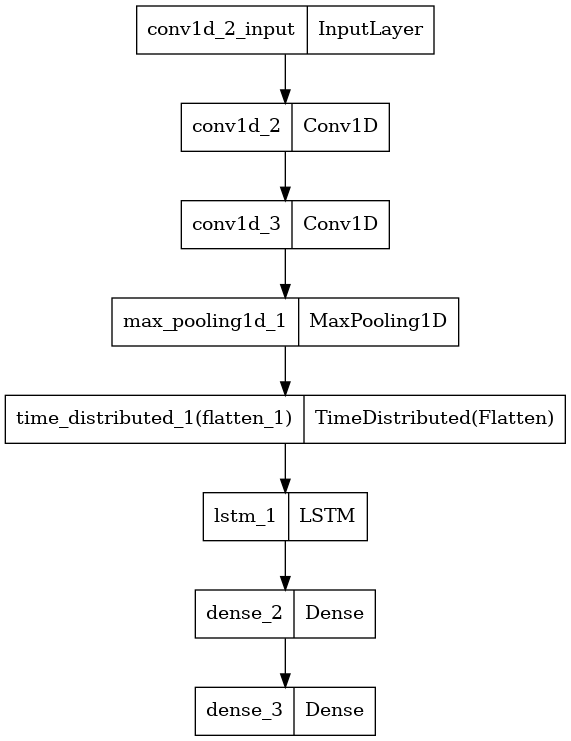

In [124]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [125]:
# # Fit the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(trainX, trainY, epochs=40, batch_size=128, validation_split=0.3, callbacks=[es], verbose=1)

Epoch 1/40
1667/1667 [==============================] - 308s 182ms/step - loss: 0.1248 - val_loss: 0.1103
Epoch 2/40
1667/1667 [==============================] - 190s 114ms/step - loss: 0.0015 - val_loss: 0.0713
Epoch 3/40
1667/1667 [==============================] - 208s 125ms/step - loss: 0.0089 - val_loss: 0.1041
Epoch 4/40
1667/1667 [==============================] - 208s 125ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 5/40
1667/1667 [==============================] - 208s 125ms/step - loss: 5.0203e-04 - val_loss: 0.0066
Epoch 6/40
1667/1667 [==============================] - 233s 140ms/step - loss: 3.8426e-04 - val_loss: 0.0051
Epoch 7/40
1667/1667 [==============================] - 216s 130ms/step - loss: 8.6931e-04 - val_loss: 0.0058
Epoch 8/40
1667/1667 [==============================] - 201s 120ms/step - loss: 7.9701e-04 - val_loss: 0.0055
Epoch 9/40
1667/1667 [==============================] - 202s 121ms/step - loss: 7.7663e-04 - val_loss: 0.0036
Epoch 10/40
1667/1667 [===

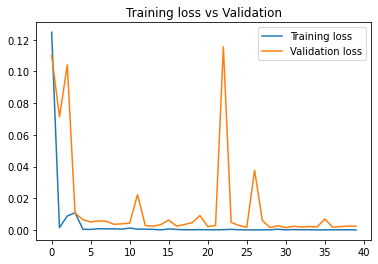

In [126]:
plot2 = plt.figure(1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Training loss vs Validation")
plt.legend()
plt.show()

## Setup Testing Data

In [127]:
# Import data for testing 

test_data = pd.read_csv("/home/deepfintech/Codes/Model/Crypto/BTCUSDT/BTCUSDT_Mar.csv")

test_data.head()

,open_time,open,high,low,close,volume,asset_volume,number_of_trades,taker_buy_base,taker_buy_quote
0,2022-03-01 00:00:00,43160.00,43226.93,43155.68,43179.84,99.84694,4.312485e+06,1981,65.92997,2.847690e+06
1,2022-03-01 00:01:00,43179.84,43262.66,43174.54,43256.94,41.22686,1.781719e+06,1527,19.05982,8.238275e+05
2,2022-03-01 00:02:00,43258.17,43529.82,43253.80,43488.96,286.95151,1.246384e+07,5742,174.84599,7.593450e+06
3,2022-03-01 00:03:00,43489.01,43503.80,43325.73,43325.73,121.73131,5.282853e+06,3151,60.76140,2.636791e+06
4,2022-03-01 00:04:00,43325.73,43447.35,43318.05,43428.83,84.30619,3.656766e+06,2276,49.25276,2.136328e+06


In [128]:
#Convert 'open_time' to data type of date_time

test_data['open_time'] = pd.to_datetime(test_data['open_time'])

test_open_times = test_data['open_time']

test_data_copy = test_data.copy()
test_open_times.shape

(43201,)

In [129]:
# Get only "open","high","low","close","volume" columns.

columns = ["open","high","low","close","volume"]
test_data = test_data[columns]
test_data.head()

,open,high,low,close,volume
0,43160.00,43226.93,43155.68,43179.84,99.84694
1,43179.84,43262.66,43174.54,43256.94,41.22686
2,43258.17,43529.82,43253.80,43488.96,286.95151
3,43489.01,43503.80,43325.73,43325.73,121.73131
4,43325.73,43447.35,43318.05,43428.83,84.30619


In [130]:
test_data['open_time'] = test_data_copy['open_time'].apply(lambda x: x.weekday()*24*60+x.hour*60+x.minute)

In [131]:
high_idx = argrelextrema(test_data['high'].values, np.greater, order=2)[0]
low_idx = argrelextrema(test_data['low'].values, np.less, order=2)[0]

close_high_idx = argrelextrema(test_data['close'].values, np.greater, order=2)[0]
close_low_idx = argrelextrema(test_data['close'].values, np.less, order=2)[0]

high_low_idx = np.sort(np.concatenate((close_high_idx, close_low_idx), axis=0), axis=0)

In [132]:
test_data["approx"] = np.nan
test_data["app_highs"] = np.nan
test_data["app_lows"] = np.nan

test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,43160.00,43226.93,43155.68,43179.84,99.84694,1440,NaN,NaN,NaN
1,43179.84,43262.66,43174.54,43256.94,41.22686,1441,NaN,NaN,NaN
2,43258.17,43529.82,43253.80,43488.96,286.95151,1442,NaN,NaN,NaN
3,43489.01,43503.80,43325.73,43325.73,121.73131,1443,NaN,NaN,NaN
4,43325.73,43447.35,43318.05,43428.83,84.30619,1444,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
43196,47088.17,47088.18,47040.21,47048.77,24.42080,4316,NaN,NaN,NaN
43197,47048.78,47058.06,47036.03,47050.51,10.48943,4317,NaN,NaN,NaN
43198,47050.51,47050.51,47001.96,47022.49,29.70143,4318,NaN,NaN,NaN
43199,47022.50,47068.00,47021.54,47067.99,15.83469,4319,NaN,NaN,NaN


In [133]:
test_data["approx"].iloc[high_low_idx] = test_data['close'].iloc[high_low_idx]
test_data["app_highs"].iloc[high_idx] = test_data['high'].iloc[high_idx]
test_data["app_lows"].iloc[low_idx] = test_data['close'].iloc[low_idx]

/home/deepfintech/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [134]:
test_data = test_data.interpolate(method='piecewise_polynomial')

In [135]:
test_data["approx"].iloc[0] = test_data['close'].iloc[0]
test_data["approx"].iloc[-1] = test_data['close'].iloc[-1]

test_data["app_highs"].iloc[0] = test_data['high'].iloc[0]
test_data["app_highs"].iloc[-1] = test_data['high'].iloc[-1]

test_data["app_lows"].iloc[0] = test_data['close'].iloc[0]
test_data["app_lows"].iloc[-1] = test_data['close'].iloc[-1]

In [136]:
test_data = test_data.interpolate(method='piecewise_polynomial')

In [137]:
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,43160.00,43226.93,43155.68,43179.84,99.84694,1440,43179.8400,43226.930000,43179.840000
1,43179.84,43262.66,43174.54,43256.94,41.22686,1441,43334.4000,43378.375000,43198.884286
2,43258.17,43529.82,43253.80,43488.96,286.95151,1442,43488.9600,43529.820000,43217.928571
3,43489.01,43503.80,43325.73,43325.73,121.73131,1443,43437.3875,43538.506667,43236.972857
4,43325.73,43447.35,43318.05,43428.83,84.30619,1444,43385.8150,43547.193333,43256.017143
...,...,...,...,...,...,...,...,...,...
43196,47088.17,47088.18,47040.21,47048.77,24.42080,4316,47087.1660,47104.392000,47044.455000
43197,47048.78,47058.06,47036.03,47050.51,10.48943,4317,47080.7740,47095.294000,47034.321250
43198,47050.51,47050.51,47001.96,47022.49,29.70143,4318,47074.3820,47086.196000,47024.187500
43199,47022.50,47068.00,47021.54,47067.99,15.83469,4319,47067.9900,47077.098000,47014.053750


<hr style="border:2px solid gray"> </hr>

### **ABCD pattern for testing**

In [138]:
test_global_min_list, test_global_max_list, test_global_min_max_list = getABCD(test_data)

<ipython-input-139-b611c58f845a>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(test_data_copy.iloc[test_global_min_max_list].open_time, test_data.iloc[test_global_min_max_list]['close'],color=colors[3], lineStyle='--')


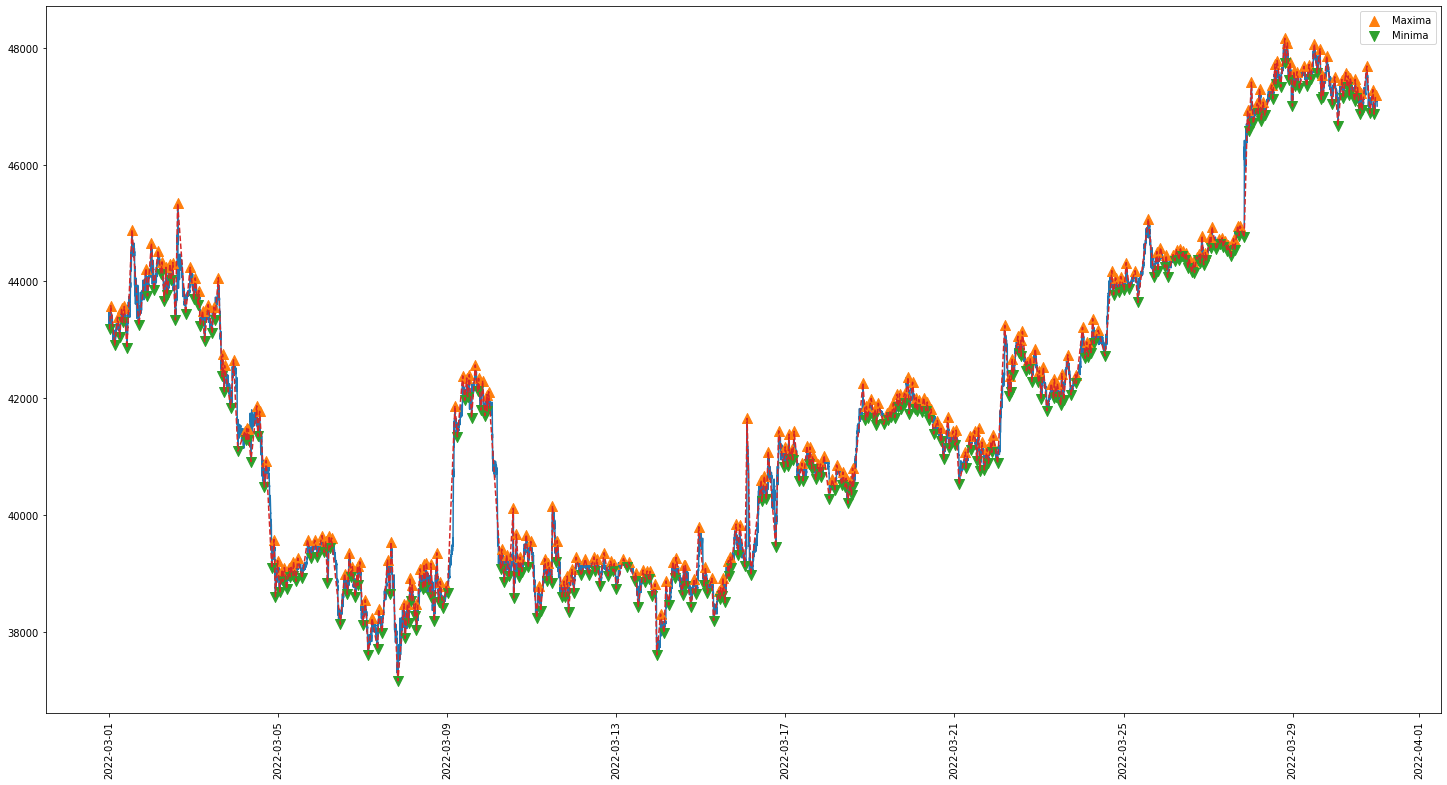

In [139]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.figure(figsize=(25, 13))
plt.plot(test_data_copy.open_time , test_data['close'], zorder=0)
plt.scatter(test_data_copy.iloc[test_global_max_list].open_time, test_data.iloc[test_global_max_list]['close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(test_data_copy.iloc[test_global_min_list].open_time, test_data.iloc[test_global_min_list]['close'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.plot(test_data_copy.iloc[test_global_min_max_list].open_time, test_data.iloc[test_global_min_max_list]['close'],color=colors[3], lineStyle='--')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [140]:
test_data['trend'] = np.nan
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,43160.00,43226.93,43155.68,43179.84,99.84694,1440,43179.8400,43226.930000,43179.840000,NaN
1,43179.84,43262.66,43174.54,43256.94,41.22686,1441,43334.4000,43378.375000,43198.884286,NaN
2,43258.17,43529.82,43253.80,43488.96,286.95151,1442,43488.9600,43529.820000,43217.928571,NaN
3,43489.01,43503.80,43325.73,43325.73,121.73131,1443,43437.3875,43538.506667,43236.972857,NaN
4,43325.73,43447.35,43318.05,43428.83,84.30619,1444,43385.8150,43547.193333,43256.017143,NaN
...,...,...,...,...,...,...,...,...,...,...
43196,47088.17,47088.18,47040.21,47048.77,24.42080,4316,47087.1660,47104.392000,47044.455000,NaN
43197,47048.78,47058.06,47036.03,47050.51,10.48943,4317,47080.7740,47095.294000,47034.321250,NaN
43198,47050.51,47050.51,47001.96,47022.49,29.70143,4318,47074.3820,47086.196000,47024.187500,NaN
43199,47022.50,47068.00,47021.54,47067.99,15.83469,4319,47067.9900,47077.098000,47014.053750,NaN


In [141]:
for count in range (len(test_global_min_max_list)-1):
    if test_global_min_max_list[count] in test_global_max_list:
        for i in range(test_global_min_max_list[count], test_global_min_max_list[count+1]):
#             print (i)
#             train_data['trend'][i] = "DOWN"
            test_data['trend'][i] = -1
    
    else:
        for i in range(test_global_min_max_list[count], test_global_min_max_list[count+1]):
#             print ("UP")
            test_data['trend'][i] = 1

<ipython-input-141-997ca03a49b6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['trend'][i] = 1
<ipython-input-141-997ca03a49b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['trend'][i] = -1


In [142]:
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,43160.00,43226.93,43155.68,43179.84,99.84694,1440,43179.8400,43226.930000,43179.840000,NaN
1,43179.84,43262.66,43174.54,43256.94,41.22686,1441,43334.4000,43378.375000,43198.884286,NaN
2,43258.17,43529.82,43253.80,43488.96,286.95151,1442,43488.9600,43529.820000,43217.928571,NaN
3,43489.01,43503.80,43325.73,43325.73,121.73131,1443,43437.3875,43538.506667,43236.972857,NaN
4,43325.73,43447.35,43318.05,43428.83,84.30619,1444,43385.8150,43547.193333,43256.017143,NaN
...,...,...,...,...,...,...,...,...,...,...
43196,47088.17,47088.18,47040.21,47048.77,24.42080,4316,47087.1660,47104.392000,47044.455000,NaN
43197,47048.78,47058.06,47036.03,47050.51,10.48943,4317,47080.7740,47095.294000,47034.321250,NaN
43198,47050.51,47050.51,47001.96,47022.49,29.70143,4318,47074.3820,47086.196000,47024.187500,NaN
43199,47022.50,47068.00,47021.54,47067.99,15.83469,4319,47067.9900,47077.098000,47014.053750,NaN


In [143]:
test_data['trend'] = test_data['trend'].interpolate(method='nearest').ffill().bfill()

test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,43160.00,43226.93,43155.68,43179.84,99.84694,1440,43179.8400,43226.930000,43179.840000,1.0
1,43179.84,43262.66,43174.54,43256.94,41.22686,1441,43334.4000,43378.375000,43198.884286,1.0
2,43258.17,43529.82,43253.80,43488.96,286.95151,1442,43488.9600,43529.820000,43217.928571,1.0
3,43489.01,43503.80,43325.73,43325.73,121.73131,1443,43437.3875,43538.506667,43236.972857,1.0
4,43325.73,43447.35,43318.05,43428.83,84.30619,1444,43385.8150,43547.193333,43256.017143,1.0
...,...,...,...,...,...,...,...,...,...,...
43196,47088.17,47088.18,47040.21,47048.77,24.42080,4316,47087.1660,47104.392000,47044.455000,1.0
43197,47048.78,47058.06,47036.03,47050.51,10.48943,4317,47080.7740,47095.294000,47034.321250,1.0
43198,47050.51,47050.51,47001.96,47022.49,29.70143,4318,47074.3820,47086.196000,47024.187500,1.0
43199,47022.50,47068.00,47021.54,47067.99,15.83469,4319,47067.9900,47077.098000,47014.053750,1.0


In [144]:
test_data.trend.value_counts()

 1.0    22166
-1.0    21035
Name: trend, dtype: int64

In [145]:
train_data.isna().sum()

open             0
high             0
low              0
close            0
volume           0
open_time        0
approx           0
app_highs        0
app_lows         0
trend            0
Hull_MA          0
ma5              0
ma8              0
ma13             0
rsi              0
macd             0
macd_signal      0
macd_hist        0
bbands_upper     0
bbands_middle    0
bbands_lower     0
obv              0
wma              0
dema             0
tema             0
adx              0
mfi              0
ppo              0
trix             0
willr            0
ultosc           0
adosc            0
ema              0
roc              0
cci              0
atr              0
ad               0
dtype: int64

<hr style="border:2px solid gray"> </hr>

### **Hull Moving Average for testing**

In [146]:
def getHullMA(df):
    df_to_hull_MA = df[['open' , 'high' , 'low' , 'close']]
    df_to_hull_MA_array = df_to_hull_MA.to_numpy()

    import numpy as np
    def lwma(Data, lookback):

        weighted = []    
        for i in range(len(Data)):
                try:
                    total = np.arange(1, lookback + 1, 1)

                    matrix = Data[i - lookback + 1: i + 1, 3:4]
                    matrix = np.ndarray.flatten(matrix)
                    matrix = total * matrix
                    wma = (matrix.sum()) / (total.sum())
                    weighted = np.append(weighted, wma)   

                except ValueError:
                    pass

        Data = Data[lookback - 1:, ]
        weighted = np.reshape(weighted, (-1, 1)) 
        Data = np.concatenate((Data, weighted), axis = 1)   

        return Data
    # For this function to work, you need to have an OHLC array composed of the four usual columns, then you can use the below syntax to get a data array with the weighted moving average using the lookback you need
    Hull_MA = pd.DataFrame(lwma(df_to_hull_MA_array, 20))[4]
    df["Hull_MA"] = Hull_MA
    return df

test_data=getHullMA(test_data)
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,Hull_MA
0,43160.00,43226.93,43155.68,43179.84,99.84694,1440,43179.8400,43226.930000,43179.840000,1.0,43347.049810
1,43179.84,43262.66,43174.54,43256.94,41.22686,1441,43334.4000,43378.375000,43198.884286,1.0,43342.767905
2,43258.17,43529.82,43253.80,43488.96,286.95151,1442,43488.9600,43529.820000,43217.928571,1.0,43335.876524
3,43489.01,43503.80,43325.73,43325.73,121.73131,1443,43437.3875,43538.506667,43236.972857,1.0,43326.915143
4,43325.73,43447.35,43318.05,43428.83,84.30619,1444,43385.8150,43547.193333,43256.017143,1.0,43318.465905
...,...,...,...,...,...,...,...,...,...,...,...
43196,47088.17,47088.18,47040.21,47048.77,24.42080,4316,47087.1660,47104.392000,47044.455000,1.0,NaN
43197,47048.78,47058.06,47036.03,47050.51,10.48943,4317,47080.7740,47095.294000,47034.321250,1.0,NaN
43198,47050.51,47050.51,47001.96,47022.49,29.70143,4318,47074.3820,47086.196000,47024.187500,1.0,NaN
43199,47022.50,47068.00,47021.54,47067.99,15.83469,4319,47067.9900,47077.098000,47014.053750,1.0,NaN


<hr style="border:2px solid blue"> </hr>

# Add other Technical Indicators

In [147]:
test_data["ma5"] = calculate_ma(test_data["close"], 5) #calculate moving average 5
test_data["ma8"] = calculate_ma(test_data["close"], 8) #calculate moving average 8
test_data["ma13"] = calculate_ma(test_data["close"], 13) #calculate moving average 13
test_data["rsi"] = calculate_rsi(test_data["close"], 14)
test_data["macd"], test_data["macd_signal"], test_data["macd_hist"] = calculate_macd(test_data["close"])
test_data["bbands_upper"], test_data["bbands_middle"] , test_data["bbands_lower"] = calculate_bbands(test_data["close"], 20)
test_data["obv"] = calculate_obv(test_data["close"] , test_data["volume"])
test_data["wma"] = calculate_wma(test_data["close"])
test_data["dema"] = calculate_dema(test_data["close"])
test_data["tema"] = calculate_tema(test_data["close"])
test_data["adx"] = calculate_adx(test_data["high"], test_data["low"], test_data["close"])
test_data["mfi"] = calculate_mfi(test_data["high"], test_data["low"], test_data["close"], test_data["volume"])
test_data["ppo"] = calculate_ppo(test_data["close"])
test_data["trix"] = calculate_trix(test_data["close"])
test_data["willr"] = calculate_willr(test_data["high"], test_data["low"], test_data["close"])
test_data["ultosc"] = calculate_ultosc(test_data["high"], test_data["low"], test_data["close"])
test_data["adosc"] = calculate_adosc(test_data["high"], test_data["low"], test_data["close"], test_data["volume"])
test_data["ema"] = calculate_ema(test_data["close"])
test_data["roc"] = calculate_roc(test_data["close"])
test_data["cci"] = calculate_cci(test_data["high"], test_data["low"], test_data["close"])
test_data["atr"] = calculate_atr(test_data["high"], test_data["low"], test_data["close"])
test_data["ad"] = calculate_ad(test_data["high"], test_data["low"], test_data["close"], test_data["volume"])

0        43179.84
1        43256.94
2        43488.96
3        43325.73
4        43428.83
           ...   
43196    47048.77
43197    47050.51
43198    47022.49
43199    47067.99
43200    47003.92
Name: close, Length: 43201, dtype: float64


<hr style="border:2px solid blue"> </hr>

In [148]:
test_data = test_data.dropna()
test_data = test_data.reset_index(drop=True)
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,...,ppo,trix,willr,ultosc,adosc,ema,roc,cci,atr,ad
0,43424.02,43448.80,43421.97,43433.14,33.96041,1480,43441.284286,43500.364,43415.777273,1.0,...,0.163557,0.011633,-45.690042,54.123074,86.218687,43415.371926,0.237270,28.204122,68.874440,411.889077
1,43433.14,43489.17,43429.91,43464.04,16.16881,1481,43458.558571,43489.170,43408.670909,1.0,...,0.166072,0.011926,-33.084486,47.125481,83.899899,43421.861002,0.290715,53.646651,68.187695,414.344684
2,43464.03,43470.93,43451.80,43455.64,11.72591,1482,43475.832857,43541.336,43401.564545,1.0,...,0.172334,0.012118,-36.511239,43.411645,80.567190,43426.364869,0.063876,45.494723,64.683573,407.326301
3,43455.63,43485.00,43437.28,43472.41,59.30233,1483,43493.107143,43593.502,43394.458182,1.0,...,0.181618,0.012298,-29.669971,53.936309,79.272427,43432.504220,-0.118073,47.550785,63.471890,435.337083
4,43474.99,43533.84,43472.41,43525.23,102.52542,1484,43510.381429,43645.668,43387.351818,1.0,...,0.186682,0.012722,-8.122221,55.636231,83.240651,43444.867657,0.010524,105.289036,63.326040,509.122673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43137,47127.85,47127.85,47104.38,47120.49,10.57942,4297,47128.521667,47170.538,47120.490000,1.0,...,0.022829,0.003423,-80.293578,48.274376,-43.228741,47145.324369,-0.065809,-195.746339,25.620626,-3218.714704
43138,47120.49,47125.41,47113.36,47117.00,6.11817,4298,47117.000000,47168.086,47120.236667,1.0,...,0.019978,0.002924,-84.562691,44.560069,-40.764855,47141.547786,-0.094674,-158.086261,24.651296,-3221.136586
43139,47117.01,47119.74,47115.22,47118.48,5.84463,4299,47114.668333,47165.634,47119.983333,1.0,...,0.017040,0.002381,-82.752294,39.338885,-38.163603,47138.472081,-0.049468,-130.528522,23.213346,-3218.550466
43140,47118.47,47119.73,47111.40,47119.73,5.37741,4300,47112.336667,47163.182,47119.730000,1.0,...,0.011498,0.001836,-81.223242,44.433585,-35.261704,47135.973137,-0.085814,-111.597917,22.150250,-3213.173056


<hr style="border:2px solid gray"> </hr>

In [149]:
columns_to_scale = list(test_data.columns)
columns_to_scale.remove('trend')

In [150]:
# scaling testing data

scaled_testing_data = scaler.fit_transform(test_data[columns_to_scale])
scaled_testing_data.shape

(43142, 36)

In [151]:
scaled_testing_data = np.c_[ scaled_testing_data,  test_data["trend"].to_numpy()] 
scaled_testing_data.shape

(43142, 37)

In [152]:
# Create testX, testY arrays in to test the model 

testX = []
testY = []

n_future = 1  # Number of minutes we want to predict into the future
n_past = 50 # Number of past minutes we want to use to predict the future (lookback period)

for i in range(n_past, len(scaled_testing_data) - n_future + 1):
    testX.append(scaled_testing_data[i - n_past:i, 0:scaled_testing_data.shape[1]])
    testY.append(scaled_testing_data[i + n_future - 1:i + n_future, 3])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (43092, 50, 37).
testY shape == (43092, 1).


In [153]:
scaled_prediction = model.predict(testX)
next_np_scaled = np.delete(scaled_testing_data, np.s_[36], axis=1) 
scaled_prediction_copies = np.repeat(scaled_prediction, next_np_scaled.shape[1], axis=-1)
prediction = scaler.inverse_transform(scaled_prediction_copies)[:, 3]
prediction

array([43316.453, 43331.11 , 43330.035, ..., 47127.445, 47125.16 ,
       47122.844], dtype=float32)

In [154]:
pd.DataFrame(prediction) 

,0
0,43316.453125
1,43331.109375
2,43330.035156
3,43319.945312
4,43324.328125
...,...
43087,47145.652344
43088,47124.882812
43089,47127.445312
43090,47125.160156


In [155]:
# Calculate Root Mean Square Error

def calculate_rmse(prediction):
    return mean_squared_error(test_data[n_past:]["close"], prediction, squared=False)

In [156]:
# Calculate Adjusted r2 score

def calculate_adj_r2(prediction):
    r2 = r2_score(test_data[n_past:]["close"], prediction)
    adjusted_r2 = 1 - ((1-r2)*(len(prediction)-1)/(len(prediction)-scaled_testing_data.shape[1]-1))
    return adjusted_r2

In [157]:
# Calculate accuracy of prediction direction

def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    #extract the "next minute's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "current's price" of tensor
    y_true_now = y_true[:-1]
    y_pred_now = y_pred[:-1]
    
    #substract to get up/down movement of the two tensors
    y_true_diff = np.subtract(y_true_next, y_true_now)
    y_pred_diff = np.subtract(y_pred_next, y_pred_now)
        
    #create a standard tensor with zero value for comparison
    standard = np.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = np.greater_equal(y_true_diff, standard)
    y_pred_move = np.greater_equal(y_pred_diff, standard)
    
    return accuracy_score(y_true_move, y_pred_move)

In [158]:
# Calculate Root Mean Square Error

print("Root Mean squared error: " + str(calculate_rmse(prediction)))

Root Mean squared error: 48.408144279592506


### Calculate profit for different gamma

In [159]:
def calculate_profit(y_true, y_pred, gamma):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    profit = 0
    
    trade_count = 0
    
    for i in range(len(y_true)-1):
        if y_pred[i+1]>=(y_true[i]*(100+gamma)/100):
            trade_count = trade_count + 1
            profit = profit + (100*y_true[i+1]/y_true[i])-100
#             print(y_true[i+1]- y_true[i])
    
    if trade_count == 0:
        return (0,0,0)
    
    return profit/trade_count, profit, trade_count

In [160]:
gamma_df = pd.DataFrame(index=range(50), columns=["gamma", "roi", "proft", "trade_count"])

In [161]:
for i in range(1,51):
    gamma_df["gamma"][i-1] = round(i/10.0,1)
    gamma_df["roi"][i-1], gamma_df["proft"][i-1], gamma_df["trade_count"][i-1] = calculate_profit(test_data[n_past:]["close"], prediction, round(i/10.0,1))

In [162]:
gamma_df

,gamma,roi,proft,trade_count
0,0.1,0.021362,106.872069,5003
1,0.2,0.039696,40.251363,1014
2,0.3,0.040959,13.107029,320
3,0.4,0.056115,6.958309,124
4,0.5,0.039681,2.420514,61
5,0.6,0.076165,2.056449,27
6,0.7,0.098691,1.480359,15
7,0.8,0.108891,1.197803,11
8,0.9,0.063869,0.447084,7
9,1.0,-0.054962,-0.274808,5


Text(0, 0.5, 'Profit')

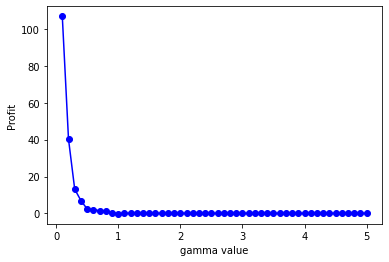

In [163]:
plot0 = plt.figure(0)
plt.plot(gamma_df["gamma"], gamma_df["proft"], "-bo")
plt.xlabel("gamma value")
plt.ylabel("Profit")

In [164]:
calculate_profit(test_data[n_past:]["close"], prediction, 0.01)

(0.00785541279492659, 199.56676205511002, 25405)

In [165]:
# Calculate Adjusted r2 score

r2 = r2_score(test_data[n_past:]["close"], prediction)
adjusted_r2 = 1 - ((1-r2)*(len(prediction)-1)/(len(prediction)-scaled_testing_data.shape[1]-1))

print("Adjusted r2 score: " + str(calculate_adj_r2(prediction)))

Adjusted r2 score: 0.9996848686620923


In [166]:
# Calculate accuracy of prediction direction

calculate_accuracy(test_data[n_past:]["close"], prediction)

0.5001972569678123

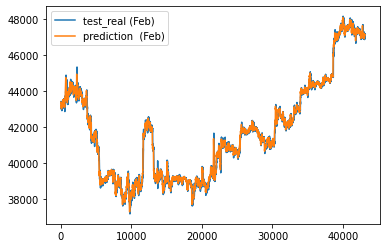

In [167]:
# Real vs Predict graph

plot2 = plt.figure(2)
plt.plot(test_data[n_past:]["close"], label="test_real (Feb)")
plt.plot(prediction, label="prediction  (Feb)")
plt.legend()
plt.show()

## For real values

In [168]:
def calculate_profit(y_true, y_pred, gamma):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    profit = 0
    
    trade_count = 0
    
    for i in range(len(y_true)-1):
        if y_true[i+1]>=(y_true[i]*(100+gamma)/100):
            trade_count = trade_count + 1
            profit = profit + (100*y_true[i+1]/y_true[i])-100
    
    if trade_count == 0:
        return (0,0,0)
    
    return profit/trade_count, profit, trade_count

In [169]:
gamma_real_df = pd.DataFrame(index=range(50), columns=["gamma", "roi", "proft", "trade_count"])

In [170]:
for i in range(1,51):
    gamma_real_df["gamma"][i-1] = round(i/10.0,1)
    gamma_real_df["roi"][i-1], gamma_real_df["proft"][i-1], gamma_real_df["trade_count"][i-1] = calculate_profit(test_data[n_past:]["close"], prediction, round(i/10.0,1))

In [171]:
gamma_real_df

,gamma,roi,proft,trade_count
0,0.1,0.169003,536.414385,3174
1,0.2,0.308555,191.921446,622
2,0.3,0.445787,95.844255,215
3,0.4,0.594548,54.698452,92
4,0.5,0.73224,35.147498,48
5,0.6,0.85768,24.872708,29
6,0.7,1.02937,16.469918,16
7,0.8,1.1223,13.467603,12
8,0.9,1.181389,11.813886,10
9,1.0,1.283033,8.981229,7


In [172]:
calculate_profit(test_data[n_past:]["close"], prediction, 0.01)

(0.06457735220371415, 1173.1121801326713, 18166)